In [1]:
import math
import scipy
import numpy as np
import pandas as pd
import math as m
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

from scipy.spatial import distance_matrix
from scipy import linalg
from scipy.optimize import minimize
from scipy.linalg import eig, eigh
from scipy.fft import fft
from scipy.special import eval_gegenbauer, sph_harm

from sklearn import svm, datasets
from sklearn.datasets import make_swiss_roll
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import kneighbors_graph, NearestNeighbors, KNeighborsClassifier
from sklearn.decomposition import KernelPCA, PCA
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#import scaleogram as scg
from matplotlib import pyplot as plt
from matplotlib import cm

import warnings

from tqdm.notebook import tqdm

from visuals import *
from my_lib import *
from SSA_lib import SSA 

In [2]:
warnings.simplefilter('ignore')

# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [3]:
def CartesianToSpherical(point):
    r = np.sqrt(sum(point ** 2))
    n = len(point)
    phi = np.zeros(n - 1)
    
    for i in range(n - 2):
        phi[i] = np.arccos(point[i] / np.sqrt(sum(point[i:] ** 2)))
        
    if point[-1] >= 0:
        phi[n - 2] = np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
    else:
        phi[n - 2] = 2 * np.pi - np.arccos(point[n - 2] / np.sqrt(point[n - 1] ** 2 + point[n - 2] ** 2))
        
    return np.hstack((phi, r))


def TrajectoryToSpherical(tr):
    tr_spherical = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_spherical[i] = CartesianToSpherical(point)
    return tr_spherical


def SphericalToCartesian(point):
    phi, r = point[:-1], point[-1]
    n = len(point)
    x = np.zeros(n) 
    cur = r
    
    for i in range(n - 1):
        x[i] = cur * np.cos(phi[i])
        cur *= np.sin(phi[i])

    x[n - 1] = cur
    return x
    

def TrajectoryToCartesian(tr):
    tr_cartesian = np.zeros(tr.shape)
    for i, point in enumerate(tr):
        tr_cartesian[i] = SphericalToCartesian(point)
    return tr_cartesian

def HankelMatrix(X, L):  
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

In [4]:
SAMPLE_N = 20

phi = np.linspace(0, 2*np.pi, SAMPLE_N)
theta = np.linspace(0, np.pi, SAMPLE_N)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

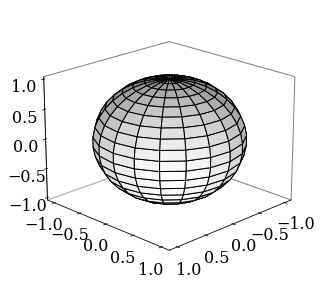

In [5]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, rstride = 1, cstride = 1, color = 'w', linewidths=1, edgecolors='k')

ax.grid(False)
ax.view_init(elev = 20, azim = 45)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

plt.show()

In [144]:
def prepare_time_series(_dir, centred = True):
    data = pd.read_csv(_dir, delimiter =';', decimal=',')
    
    frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])
    
    assert 490 < frequency < 510, f'Bad frequency {frequency}'

    _x = ((data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
    
    if centred:
        _m = np.mean(_x)
        _x = (_x-_m)
        
    _t = (data['time'].values).astype(float).reshape([-1,])

    _t = np.linspace(0,_t[-1]-_t[0],len(_x))
        
    return _x,_t

In [460]:
# dir_list = ['wlk_8', 'jog_9', 'ups_4']
# sub_num = 1
# class_motion = dir_list[1]

# df = pd.read_csv(f'./data/A_DeviceMotion_data/{class_motion}/sub_{sub_num}.csv')
# x_1 = df[['gravity.x', 'gravity.y','gravity.z']].to_numpy()*9.8
# x_2 = df[['userAcceleration.x', 'userAcceleration.y','userAcceleration.z']].to_numpy()*9.8
# x = x_1+x_2
# x_acc = np.sum(x**2,axis = 1)**.5 - 9.8

dt = 450 * 10
data = pd.read_csv('data/long_walk_100_acc.csv', delimiter =';', decimal=',')[7101:7101+dt]

frequency = len(data)/(data['time'].values[-1]-data['time'].values[0])

assert 490 < frequency < 510, f'Bad frequency {frequency}'
print(f'Frequency {frequency}')

x_acc = ( (data['X_value'].values)**2 + (data['Y_value'].values)**2 + (data['Z_value'].values)**2)**.5
_m = np.mean(x_acc)
_std = (sum((x_acc - _m)**2)/len(x_acc))**.5

x_acc = (x_acc-_m)

pca_model = PCA(n_components = 3)
X = HankelMatrix(x_acc, 500)
X_PCA = pca_model.fit_transform(X)[:,:]

ax = 0/180 * np.pi
ay = 0/180 * np.pi
az = 0/180 * np.pi

T_X = np.array([[1,0,0],
                [0,np.cos(ax),-np.sin(ax)],
                [0,np.sin(ax), np.cos(ax)]])

T_Y = np.array([[np.cos(ay),-np.sin(ay),0],
                [np.sin(ay), np.cos(ay),0],
                [0,0,1]])

T_Z = np.array([[ np.cos(az), 0, np.sin(az)],
                [ 0,1,0],
                [-np.sin(az), 0, np.cos(az)]])

X_PCA = X_PCA@T_Y@T_X@T_Z

# X_PCA = X_PCA/(np.sum(X_PCA**2, axis = 1)**0.5).reshape(-1,1)
Y_1 = np.ones((X_PCA.shape[0],1))


fig_2 = go.Figure()
fig_2.update_layout(autosize = False, width = 1000, height = 1000)

fig_2.add_trace(go.Scatter3d(x = X_PCA[:, 0],
                             y = X_PCA[:, 1],
                             z = X_PCA[:, 2],
                             mode='lines'
                            )
                )


fig_2.layout.template = 'plotly_white'
fig_2.show()

Frequency 500.055561729081


In [461]:
X_PCA = TrajectoryToSpherical(X_PCA)
X_PCA[:,2] = 1
X_PCA = TrajectoryToCartesian(X_PCA)

In [462]:
SAMPLE_N = 200

phi = np.linspace(0, 2*np.pi, SAMPLE_N)
theta = np.linspace(0, np.pi, SAMPLE_N)
phi, theta = np.meshgrid(phi, theta)

x = np.sin(theta) * np.cos(phi)
y = np.sin(theta) * np.sin(phi)
z = np.cos(theta)

In [463]:
X_grid = np.concatenate([x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)], axis = 1)
Y_0 = np.zeros((X_grid.shape[0],1))

In [464]:
X_all = np.concatenate((X_PCA,X_grid),axis = 0)
Y_all = np.concatenate((Y_1,Y_0),axis = 0)

In [465]:
X_grid.max(axis=0)

array([0.99996885, 0.99993769, 1.        ])

In [466]:
# clf = KNeighborsClassifier(n_neighbors = 10)
# clf.fit(X_all, Y_all)

# X_grid = np.concatenate([x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)], axis = 1)

# proba = (clf.predict_proba(X_grid)[:,1] > 0).astype(float).reshape(SAMPLE_N, SAMPLE_N)

In [467]:
proba = Y_0.copy()

nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_grid)

X = np.concatenate((X_PCA[:,0:1],X_PCA[:,1:2],X_PCA[:,2:]), axis = 1)

nn_indeces = nn.kneighbors(X, 1, return_distance=False)
proba[nn_indeces] = 1

proba = proba.reshape(SAMPLE_N, SAMPLE_N)

In [468]:
# proba

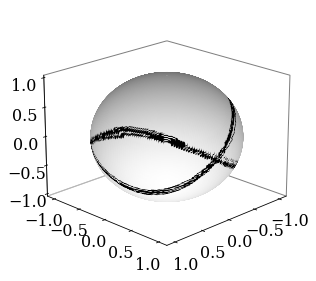

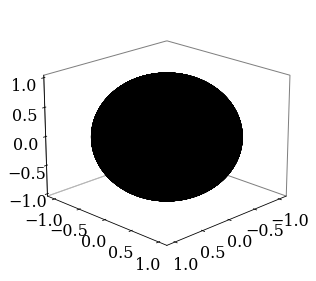

In [469]:
fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111,projection='3d')



ax.plot_surface(
    x, y, z,
    rstride = 1,
    cstride = 1,
    facecolors = cm.binary(proba),
    linewidths = 3,
#     edgecolors = 'k',
    alpha = 1
)
# ax.plot_wireframe(x, y, z, edgecolors='k', alpha = 1)


# ax.scatter(X_PCA[:,0], X_PCA[:,1], X_PCA[:,2])

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.view_init(elev = 20, azim = 45)

fig.tight_layout()
# fig.savefig(f'./images_paper/pi_walk.eps', format='eps', dpi = 200, bbox_inches = 'tight')
fig.show()

fig = plt.figure(figsize=(4,4))

ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z, rstride = 1, cstride = 1, color = 'w', linewidths = 2, edgecolors='k')

ax.grid(False)
ax.view_init(elev = 20, azim = 45)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False


plt.tight_layout()
# plt.savefig(f'./images_paper/sphere_grid.eps', format='eps', dpi = 200, bbox_inches = 'tight')
plt.show()